## 1. Load the required libraries

In [1]:
!pip install tensorflow

In [2]:
!pip install imblearn

In [3]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

sns.set(style='darkgrid')
%matplotlib inline

## 2. Download the CICIDS2017 dataset

In [4]:
!wget https://github.com/cyber-enthusiast-1/CIC-Datasets/blob/master/datasets/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.zip?raw=true -O dataset.zip
!unzip -u dataset.zip

--2025-04-13 10:37:07--  https://github.com/cyber-enthusiast-1/CIC-Datasets/blob/master/datasets/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.zip?raw=true
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/cyber-enthusiast-1/CIC-Datasets/raw/refs/heads/master/datasets/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.zip [following]
--2025-04-13 10:37:07--  https://github.com/cyber-enthusiast-1/CIC-Datasets/raw/refs/heads/master/datasets/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/cyber-enthusiast-1/CIC-Datasets/refs/heads/master/datasets/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.zip [following]
--2025-04-13 10:37:07--  https://media.githubusercontent.com/media/cyber-

## 3. Load the dataset

In [5]:
# load the dataset
df = pd.read_csv('Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv', delimiter=',')
df.head(3)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,389,113095465,48,24,9668,10012,403,0,201.416667,203.548293,...,32,203985.500,5.758373e+05,1629110,379,13800000.0,4.277541e+06,16500000,6737603,BENIGN
1,389,113473706,68,40,11364,12718,403,0,167.117647,171.919413,...,32,178326.875,5.034269e+05,1424245,325,13800000.0,4.229413e+06,16500000,6945512,BENIGN
2,0,119945515,150,0,0,0,0,0,0.000000,0.000000,...,0,6909777.333,1.170000e+07,20400000,6,24400000.0,2.430000e+07,60100000,5702188,BENIGN


# Data Preprocessing

## 1. Clean the dataset

In [ ]:
df.shape

(170366, 79)

In [ ]:
# inspect the field names in the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170366 entries, 0 to 170365
Data columns (total 79 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0    Destination Port             170366 non-null  int64  
 1    Flow Duration                170366 non-null  int64  
 2    Total Fwd Packets            170366 non-null  int64  
 3    Total Backward Packets       170366 non-null  int64  
 4   Total Length of Fwd Packets   170366 non-null  int64  
 5    Total Length of Bwd Packets  170366 non-null  int64  
 6    Fwd Packet Length Max        170366 non-null  int64  
 7    Fwd Packet Length Min        170366 non-null  int64  
 8    Fwd Packet Length Mean       170366 non-null  float64
 9    Fwd Packet Length Std        170366 non-null  float64
 10  Bwd Packet Length Max         170366 non-null  int64  
 11   Bwd Packet Length Min        170366 non-null  int64  
 12   Bwd Packet Length Mean       170366 non-nul

In [6]:
# define a function to remove starting space and the columns consistent
def rename_column(column):
  return column.strip().lower().replace(' ', '_')

In [7]:
# apply the function to the dataset
df = df.rename(columns=rename_column)
df.columns

Index(['destination_port', 'flow_duration', 'total_fwd_packets',
       'total_backward_packets', 'total_length_of_fwd_packets',
       'total_length_of_bwd_packets', 'fwd_packet_length_max',
       'fwd_packet_length_min', 'fwd_packet_length_mean',
       'fwd_packet_length_std', 'bwd_packet_length_max',
       'bwd_packet_length_min', 'bwd_packet_length_mean',
       'bwd_packet_length_std', 'flow_bytes/s', 'flow_packets/s',
       'flow_iat_mean', 'flow_iat_std', 'flow_iat_max', 'flow_iat_min',
       'fwd_iat_total', 'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max',
       'fwd_iat_min', 'bwd_iat_total', 'bwd_iat_mean', 'bwd_iat_std',
       'bwd_iat_max', 'bwd_iat_min', 'fwd_psh_flags', 'bwd_psh_flags',
       'fwd_urg_flags', 'bwd_urg_flags', 'fwd_header_length',
       'bwd_header_length', 'fwd_packets/s', 'bwd_packets/s',
       'min_packet_length', 'max_packet_length', 'packet_length_mean',
       'packet_length_std', 'packet_length_variance', 'fin_flag_count',
       'syn_flag_co

In [ ]:
# display unique value for label column
df['label'].unique()

array(['BENIGN', 'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection'], dtype=object)

In [ ]:
df['label'].value_counts()

,count
label,
BENIGN,168186
Web Attack � Brute Force,1507
Web Attack � XSS,652
Web Attack � Sql Injection,21


In [8]:
# rename the label value correctly
label_map = {
    'BENIGN': 'Benign',
    'Web Attack � Brute Force': 'Web Attack - Brute Force',
    'Web Attack � XSS': 'Web Attack - XSS',
    'Web Attack � Sql Injection': 'Web Attack - Sql Injection'
}

df.label = df.label.map(label_map)
df.label.unique()

array(['Benign', 'Web Attack - Brute Force', 'Web Attack - XSS',
       'Web Attack - Sql Injection'], dtype=object)

In [ ]:
df.shape

(170366, 79)

In [ ]:
for column in df.columns:
  if df[column].isnull().sum() > 0:
    print(f'{column} has {df[column].isnull().sum()} missing values')

flow_bytes/s has 20 missing values


## 2. Exploratory Data Analysis (EDA)

In [ ]:
# descriptive statistical analysis for the first 10 columns
df.describe().T[:10]

,count,mean,std,min,25%,50%,75%,max
destination_port,170366.0,7.897091e+03,1.823549e+04,0.0,53.000000,80.0,443.000000,6.552900e+04
flow_duration,170366.0,1.246354e+07,3.193852e+07,-1.0,192.000000,31412.0,816981.750000,1.200000e+08
total_fwd_packets,170366.0,1.512462e+01,1.123108e+03,1.0,1.000000,2.0,4.000000,2.007550e+05
total_backward_packets,170366.0,1.802228e+01,1.494493e+03,0.0,1.000000,2.0,2.000000,2.706860e+05
total_length_of_fwd_packets,170366.0,5.569859e+02,7.710431e+03,0.0,31.000000,68.0,148.000000,1.197199e+06
total_length_of_bwd_packets,170366.0,3.183147e+04,3.460816e+06,0.0,6.000000,134.0,328.000000,6.270000e+08
fwd_packet_length_max,170366.0,1.677760e+02,4.612992e+02,0.0,23.000000,41.0,60.000000,2.336000e+04
fwd_packet_length_min,170366.0,2.269779e+01,3.799078e+01,0.0,0.000000,6.0,41.000000,1.729000e+03
fwd_packet_length_mean,170366.0,4.823325e+01,9.494782e+01,0.0,7.882314,38.0,50.000000,4.183057e+03
fwd_packet_length_std,170366.0,4.723563e+01,1.419274e+02,0.0,0.000000,0.0,17.897858,5.463494e+03


<ipython-input-16-50fb171b9b98>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='label', palette='coolwarm')


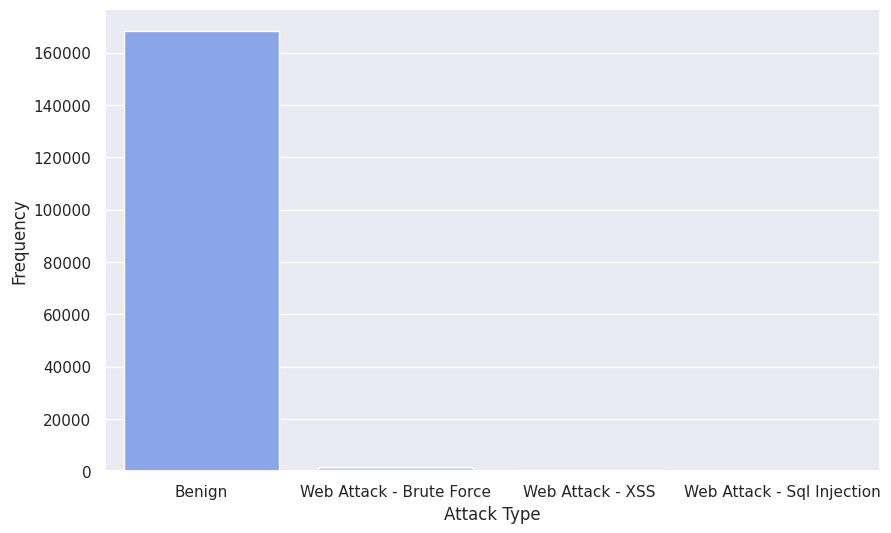

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='label', palette='coolwarm')
plt.ylabel('Frequency')
plt.xlabel('Attack Type')
plt.show()

the above bar chart indicates that normal traffic is experienced within the system. However, one cannot dismiss the different attacks such as Brute Force, XSS, SQL Injection all web attacks. Either is these attacks can lead to loss of valuable data.

In Machine learning this bar charts indicates that there is a class imbalance in the dataset. With this imbalance, training a Machine Learning model with this data could to inaccurate prediciton because the model will have memorized the data leading to overfitting. Therefore, measures such as SMOTE can be used to ensure that the data is not imbalance.

In [9]:
df.label.value_counts()

,count
label,
Benign,168186
Web Attack - Brute Force,1507
Web Attack - XSS,652
Web Attack - Sql Injection,21


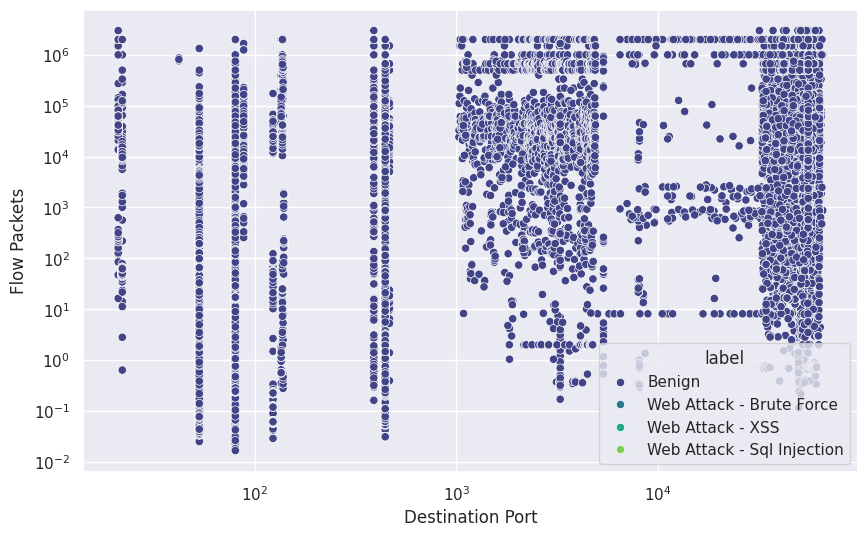

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='destination_port', y='flow_packets/s', hue='label', palette = 'viridis')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Flow Packets')
plt.xlabel('Destination Port')
plt.show()

In [10]:
# split the dataset
X = df.drop(labels= ['label'], axis=1)
y = df['label']

print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

X shape: (170366, 78)
y shape: (170366,)


## Preprocess the data for before Training A Deep Neural Network

In [ ]:
# check for infinite values
for column in X.columns: # print the columns with infinite numbers
  if np.isinf(X[column]).sum() > 0:
    print(f'the number of missing value in {column} is {np.isinf(X[column]).sum()}')

the number of missing value in flow_bytes/s is 115
the number of missing value in flow_packets/s is 135


In [ ]:
# check for missing values
for column in X.columns:
  if np.isnan(X[column]).sum() > 0:
    print(f'the number of missing value in {column} is {np.isnan(X[column]).sum()}')

the number of missing value in flow_bytes/s is 20


In [11]:
# replace the infinite values with nan values
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# confirm that the infinite values have been replaced
for column in X.columns: # print the columns with infinite numbers
  if np.isinf(X[column]).sum() > 0:
    print(f'the number of missing value in {column} is {np.isinf(X[column]).sum()}')


In [ ]:
# number of NaN values increases after replacing infinite numbers

# check for missing values
for column in X.columns:
  if np.isnan(X[column]).sum() > 0:
    print(f'the number of missing value in {column} is {np.isnan(X[column]).sum()}')

the number of missing value in flow_bytes/s is 135
the number of missing value in flow_packets/s is 135


In [12]:
# drop NaN values
X.dropna(inplace=True)
for column in X.columns:
  if np.isnan(X[column]).sum() > 0:
    print(f'the number of missing value in {column} is {np.isnan(X[column]).sum()}')

In [13]:
# ensure to drop the same rows in the target columns as in X features
y = y.loc[X.index]

In [16]:
X.shape, y.shape

((170231, 78), (170231,))

In [ ]:
y.value_counts()

,count
label,
Benign,168051
Web Attack - Brute Force,1507
Web Attack - XSS,652
Web Attack - Sql Injection,21


In [14]:
# convert label values from string to integer
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(dict(zip(le.classes_, le.transform(le.classes_))))

{'Benign': np.int64(0), 'Web Attack - Brute Force': np.int64(1), 'Web Attack - Sql Injection': np.int64(2), 'Web Attack - XSS': np.int64(3)}


In [34]:
y.dtype

dtype('O')

In [ ]:
X

In [15]:
# remove class imbalance using SMOTE technique
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y_encoded)

In [39]:
y_resampled.dtype

dtype('int64')

In [41]:
y_resampled.shape

(672204,)

In [16]:
# scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

In [17]:
#### Perform Dimensionality Reduction using Principal Component Analysis
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print(f"Reduced to {X_pca.shape[1]} components.")

Reduced to 20 components.


In [18]:
# save the scaler and pca objects
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(pca, 'pca.pkl')

['pca.pkl']

In [19]:
X_lstm = X_pca.reshape((X_pca.shape[0], X_pca.shape[1], 1))
X_lstm.shape

(672204, 20, 1)

In [20]:
# split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

In [21]:
X_train.shape, y_train.shape

((537763, 20, 1), (537763,))

#### Train Deep Neural Nerwork Model

In [28]:
X_train.shape[2]

1

In [29]:
y_train.shape

(537763,)

In [31]:
model = Sequential()

# First LSTM layer
model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))

# Second LSTM layer
model.add(LSTM(64))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(len(le.classes_), activation='softmax'))

# Compile the model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [32]:
model.summary(line_length=100)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                               ┃ Output Shape                    ┃           Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                              │ (None, 20, 128)                 │            66,560 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ dropout_4 (Dropout)                        │ (None, 20, 128)                 │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ lstm_3 (LSTM)                              │ (None, 64)                      │            49,408 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ dropout_5 (Dropout)                        │ (None, 64)                      │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ dense_4 (Dense)                            │ (None, 4)                       │               260 │
└────────────────────────────────────────────┴─────────────────────────────────┴───────────────────┘

 Total params: 116,228 (454.02 KB)

 Trainable params: 116,228 (454.02 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/10
13445/13445 ━━━━━━━━━━━━━━━━━━━━ 115s 8ms/step - accuracy: 0.7372 - loss: 0.4859 - val_accuracy: 0.8042 - val_loss: 0.3797
Epoch 2/10
13445/13445 ━━━━━━━━━━━━━━━━━━━━ 136s 8ms/step - accuracy: 0.7799 - loss: 0.3891 - val_accuracy: 0.8048 - val_loss: 0.3656
Epoch 3/10
13445/13445 ━━━━━━━━━━━━━━━━━━━━ 143s 8ms/step - accuracy: 0.8055 - loss: 0.3710 - val_accuracy: 0.8072 - val_loss: 0.3603
Epoch 4/10
13445/13445 ━━━━━━━━━━━━━━━━━━━━ 136s 8ms/step - accuracy: 0.8087 - loss: 0.3626 - val_accuracy: 0.8082 - val_loss: 0.3545
Epoch 5/10
13445/13445 ━━━━━━━━━━━━━━━━━━━━ 143s 8ms/step - accuracy: 0.8118 - loss: 0.3560 - val_accuracy: 0.8098 - val_loss: 0.3479
Epoch 6/10
13445/13445 ━━━━━━━━━━━━━━━━━━━━ 148s 8ms/step - accuracy: 0.8126 - loss: 0.3532 - val_accuracy: 0.8177 - val_loss: 0.3507
Epoch 7/10
13445/13445 ━━━━━━━━━━━━━━━━━━━━ 134s 8ms/step - accuracy: 0.8137 - loss: 0.3506 - val_accuracy: 0.8195 - val_loss: 0.3344
Epoch 8/10
13445/13445 ━━━━━━━━━━━━━━━━━━━━ 111s 8ms/step - ac

In [34]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")

4202/4202 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.8159 - loss: 0.3390
Test Accuracy: 81.49%


In [35]:
model.save('web-attack.keras')

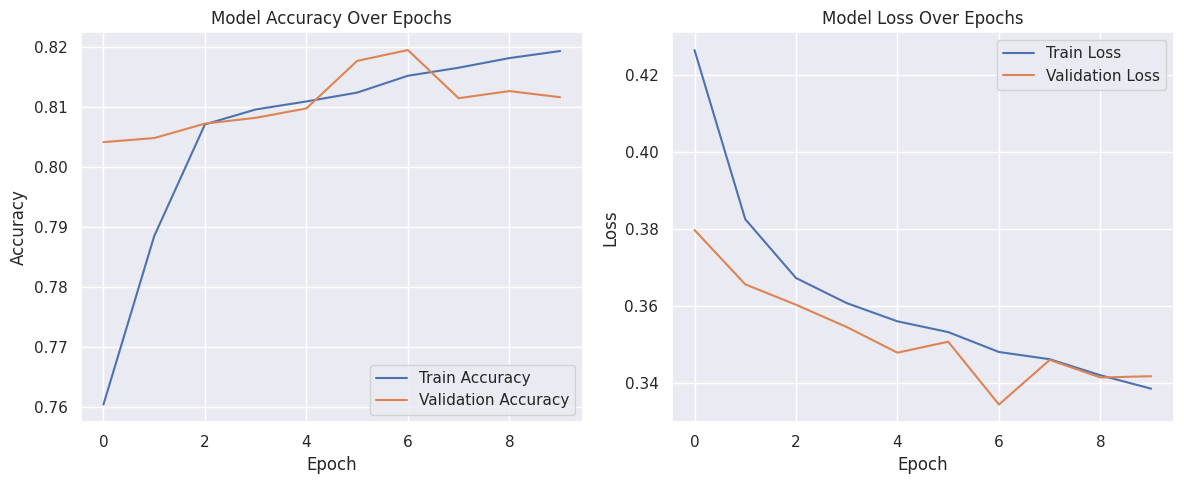

In [36]:
# plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()